In [1]:
import xarray as xr
import glob
import numpy as np

import tensorflow as tf

from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colors
import cmasher as cmr

import sys
sys.path.append("functions/")

import preprocessing
import experiment_settings
import build_model
import metricplots
import allthelinalg
import analysisplots

import importlib as imp

# pretty plots
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.sans-serif']=['Verdana']

params = {"ytick.color": "k",
          "xtick.color": "k",
          "axes.labelcolor": "k",
          "axes.edgecolor": "k"}
plt.rcParams.update(params)

In [2]:
imp.reload(preprocessing)
imp.reload(experiment_settings)
imp.reload(build_model)
imp.reload(metricplots)
imp.reload(allthelinalg)
imp.reload(analysisplots)

<module 'analysisplots' from '/Users/egordon4/Documents/Experiments/NPac_MultiYear_SkillComponentAnalysis/functions/analysisplots.py'>

### Load all the experiment deets

In [3]:
modelpath = "models/"
experiment_name = "allcmodel-tos_allcmodel-tos_2-9yearlead_flexavg"
experiment_dict = experiment_settings.get_experiment_settings(experiment_name)
filefront = experiment_dict["filename"]
filename = modelpath + experiment_dict["filename"]
modellist = experiment_dict["modellist"]
outbounds = experiment_dict["outbounds"]
trainvariants = experiment_dict["trainvariants"]
valvariants = experiment_dict["valvariants"]
testvariants = experiment_dict["testvariants"]
seedlist = experiment_dict["seeds"]
inputrun = experiment_dict["inputrun"]
outputrun = experiment_dict["outputrun"]
leadtime = experiment_dict["leadtime"]
year1 = 1851+inputrun

lon, lat = preprocessing.outlonxlat(experiment_dict)
lon = np.asarray(lon)
lat = np.asarray(lat)
centre = (outbounds[2]+outbounds[3])/2
projection = ccrs.EqualEarth(central_longitude=centre)
inres = experiment_dict["inres"]
transform = ccrs.PlateCarree()
obsyearvec = np.arange(1870+inputrun+outputrun+1,2024,)
modelyearvec = np.arange(year1+inputrun+outputrun+leadtime,2015)
latvec = np.arange(-90+inres/2,90+inres/2,inres)
lonvec = np.arange(0+inres/2,360+inres/2,inres)

weights = np.meshgrid(lon,lat)[1]
latweights = np.sqrt(np.cos(np.deg2rad(weights)))

### Also load in the preprocessed data

In [4]:
datafile = "processed_data/" + filefront + ".npz"

datamat = np.load(datafile)

allinputdata = datamat["allinputdata"]
alloutputdata = datamat["alloutputdata"]

trainvaltest = [trainvariants,valvariants,testvariants]

inputdata,inputval,inputtest,outputdata,outputval,outputtest = preprocessing.splitandflatten(
    allinputdata,alloutputdata,trainvaltest,experiment_dict["inputrun"])

inputdata[:, np.isnan(np.mean(inputdata, axis=0))] = 0
inputval[:, np.isnan(np.mean(inputval, axis=0))] = 0
inputtest[:, np.isnan(np.mean(inputtest, axis=0))] = 0

outputstd = np.std(outputdata, axis=0, keepdims=True)
outputdata = outputdata/outputstd
outputval = outputval/outputstd
outputtest = outputtest/outputstd

outputdata[:, np.isnan(np.mean(outputdata, axis=0))] = 0
outputval[:, np.isnan(np.mean(outputval, axis=0))] = 0
outputtest[:, np.isnan(np.mean(outputtest, axis=0))] = 0  

nvars = int(len(valvariants)*len(modellist))
nvariant = len(testvariants)
nmodels = len(modellist)
ntimesteps = int(len(outputtest)/(nvariant*nmodels))
n1model = ntimesteps*nvariant

mask = np.copy(outputtest)
mask[mask==0] = np.nan
landmask = ~np.isnan(np.mean(mask,axis=0))
latweights[~landmask] = 0

conversion done


### Also also load in obs

In [5]:
inputobs_ERSST,outputobs_ERSST = preprocessing.make_inputoutput_flexavg_obs(experiment_dict,"ERSST")
inputobs_ERSST,outputobs_ERSST = preprocessing.concatobs(inputobs_ERSST,outputobs_ERSST,outputstd,inputrun)

inputobs_HadISST,outputobs_HadISST = preprocessing.make_inputoutput_flexavg_obs(experiment_dict,"HadISST")
inputobs_HadISST,outputobs_HadISST = preprocessing.concatobs(inputobs_HadISST,outputobs_HadISST,outputstd,inputrun)

### Some useful analysis functions to have here and not in an external file whatever

In [6]:
def reshapengrab(inputmatrix,ind,nmodels,nvariants):

    # grabs all variants (nvariant) for a single climate model data (ind of nmodel) 
    inputshape = inputmatrix.shape
    ntimesteps = int(inputshape[0]/(nmodels*nvariants))
    if len(inputshape) == 3:        
        intmatrix = np.reshape(inputmatrix,(nmodels,nvariants,ntimesteps,inputshape[1],inputshape[2]))
    else:
        intmatrix = np.reshape(inputmatrix,(nmodels,nvariants,ntimesteps,inputshape[1],inputshape[2],inputshape[3]))
    
    outputint = intmatrix[ind]
    if len(inputshape) == 3:
        shapeout = (ntimesteps*nvariants,inputshape[1],inputshape[2])
    else:
        shapeout = (ntimesteps*nvariants,inputshape[1],inputshape[2],inputshape[3])
    outputmatrix = np.reshape(outputint,shapeout)    
    
    return outputmatrix

def model_member_corr(pattern,outputtest,y_pred_test,outputval,y_pred_val,nmodels,nvariant,landmask):
    
    modelpearsons = np.empty((nmodels,nvariant))
    modelps = np.empty((nmodels,nvariant))
    
    #modelpearsonsall = np.empty((nmodels))

    patterndims = len(pattern.shape)
    
    for imodel in range(nmodels):
             
        outputtestloop = reshapengrab(outputtest,imodel,nmodels,nvariant)    
        y_pred_testloop = reshapengrab(y_pred_test,imodel,nmodels,nvariant)    
        if patterndims == 2:            
            for imem in range(nvariant):
                outputtest_singlemem = outputtestloop[ntimesteps*imem:ntimesteps*(imem+1)]
                y_pred_test_singlemem = y_pred_testloop[ntimesteps*imem:ntimesteps*(imem+1)]
        
                modelpearsons[imodel,imem],modelps[imodel,imem] = allthelinalg.corr_indextimeseries(
                    pattern,outputtest_singlemem,y_pred_test_singlemem,outputval,y_pred_val,landmask)
        
        elif patterndims == 3:
            for imem in range(nvariant):
                outputtest_singlemem = outputtestloop[ntimesteps*imem:ntimesteps*(imem+1)]
                y_pred_test_singlemem = y_pred_testloop[ntimesteps*imem:ntimesteps*(imem+1)]
        
                modelpearsons[imodel,imem],modelps[imodel,imem] = allthelinalg.corr_indextimeseries(
                    pattern[imodel],outputtest_singlemem,y_pred_test_singlemem,outputval,y_pred_val,landmask)
    
    return modelpearsons

def model_member_err(pattern,outputtest,y_pred_test,outputval,y_pred_val,nmodels,nvariant,landmask):

    modelerrs = np.empty((nmodels,nvariant))
    patterndims = len(pattern.shape)
    
    for imodel in range(nmodels):
             
        outputtestloop = reshapengrab(outputtest,imodel,nmodels,nvariant)    
        y_pred_testloop = reshapengrab(y_pred_test,imodel,nmodels,nvariant)    
        if patterndims == 2:            
            for imem in range(nvariant):
                outputtest_singlemem = outputtestloop[ntimesteps*imem:ntimesteps*(imem+1)]
                y_pred_test_singlemem = y_pred_testloop[ntimesteps*imem:ntimesteps*(imem+1)]
        
                modelerrs[imodel,imem] = allthelinalg.err_indextimeseries(
                    pattern,outputtest_singlemem,y_pred_test_singlemem,outputval,y_pred_val,landmask)
        
        elif patterndims == 3:
            for imem in range(nvariant):
                outputtest_singlemem = outputtestloop[ntimesteps*imem:ntimesteps*(imem+1)]
                y_pred_test_singlemem = y_pred_testloop[ntimesteps*imem:ntimesteps*(imem+1)]
        
                modelerrs[imodel,imem] = allthelinalg.err_indextimeseries(
                    pattern[imodel],outputtest_singlemem,y_pred_test_singlemem,outputval,y_pred_val,landmask)
    
    return modelerrs                                                                                                

def weightedMSE(y_pred,y_true,weights):
    err = ((y_pred-y_true)*weights)
    sqerr = err**2
    mse = np.mean(sqerr)
    return mse

### Load in each trained CNN
Load in the CNNs and predict the validation data and then perform SCA on the output timeseries.
Here we calculate the first skill component, **q** from the validation data with **q** defined as

$$ \Sigma_E \mathbf q = \lambda \Sigma_V \mathbf q$$

Where $\Sigma_E$ is the error covariance matrix, and $\Sigma_V$ is the verification covariance (in this case, the covariance of the validation data). Here, we grab the first skill component, i.e., the component that corresponds to the lowest $\lambda$.

In [7]:
domainMSE = []
SCMSE = []

for random_seed in seedlist:

    fileout = filename + "_seed=" + str(random_seed) +".h5"

    tf.random.set_seed(random_seed)
    np.random.seed(random_seed) 
    
    full_model = build_model.build_CNN_full(inputdata, outputdata, 
                                                    experiment_dict, random_seed)  
    
    full_model.compile(optimizer=tf.keras.optimizers.legacy.SGD(experiment_dict["learning_rate"]),  # optimizer
                        loss=tf.keras.losses.MeanSquaredError(), 
                      )

    full_model.load_weights(fileout)
    
    full_model.trainable = False # freeze BN

    y_pred_val = full_model.predict(inputval) 
    
    bestpattern = allthelinalg.calculate_SC_weighted(y_pred_val,outputval,landmask,latweights)   
    SCtimeseries_true = allthelinalg.index_timeseries(outputval,bestpattern,landmask)
    SCtimeseries_pred = allthelinalg.index_timeseries(y_pred_val,bestpattern,landmask)
    SCtimeseries_err = np.mean((SCtimeseries_true-SCtimeseries_pred)**2)
    
    mse = weightedMSE(y_pred_val,outputval,latweights)
    domainMSE.append(mse)
    SCMSE.append(mse)

domainMSE = np.asarray(domainMSE)
bestseed = np.argmin(domainMSE)


327/327 [==============================] - 1s 3ms/step


In [8]:
domainMSE

array([0.43693757, 0.43152641, 0.43204656, 0.43140496, 0.43427146])

327/327 [==============================] - 1s 3ms/step


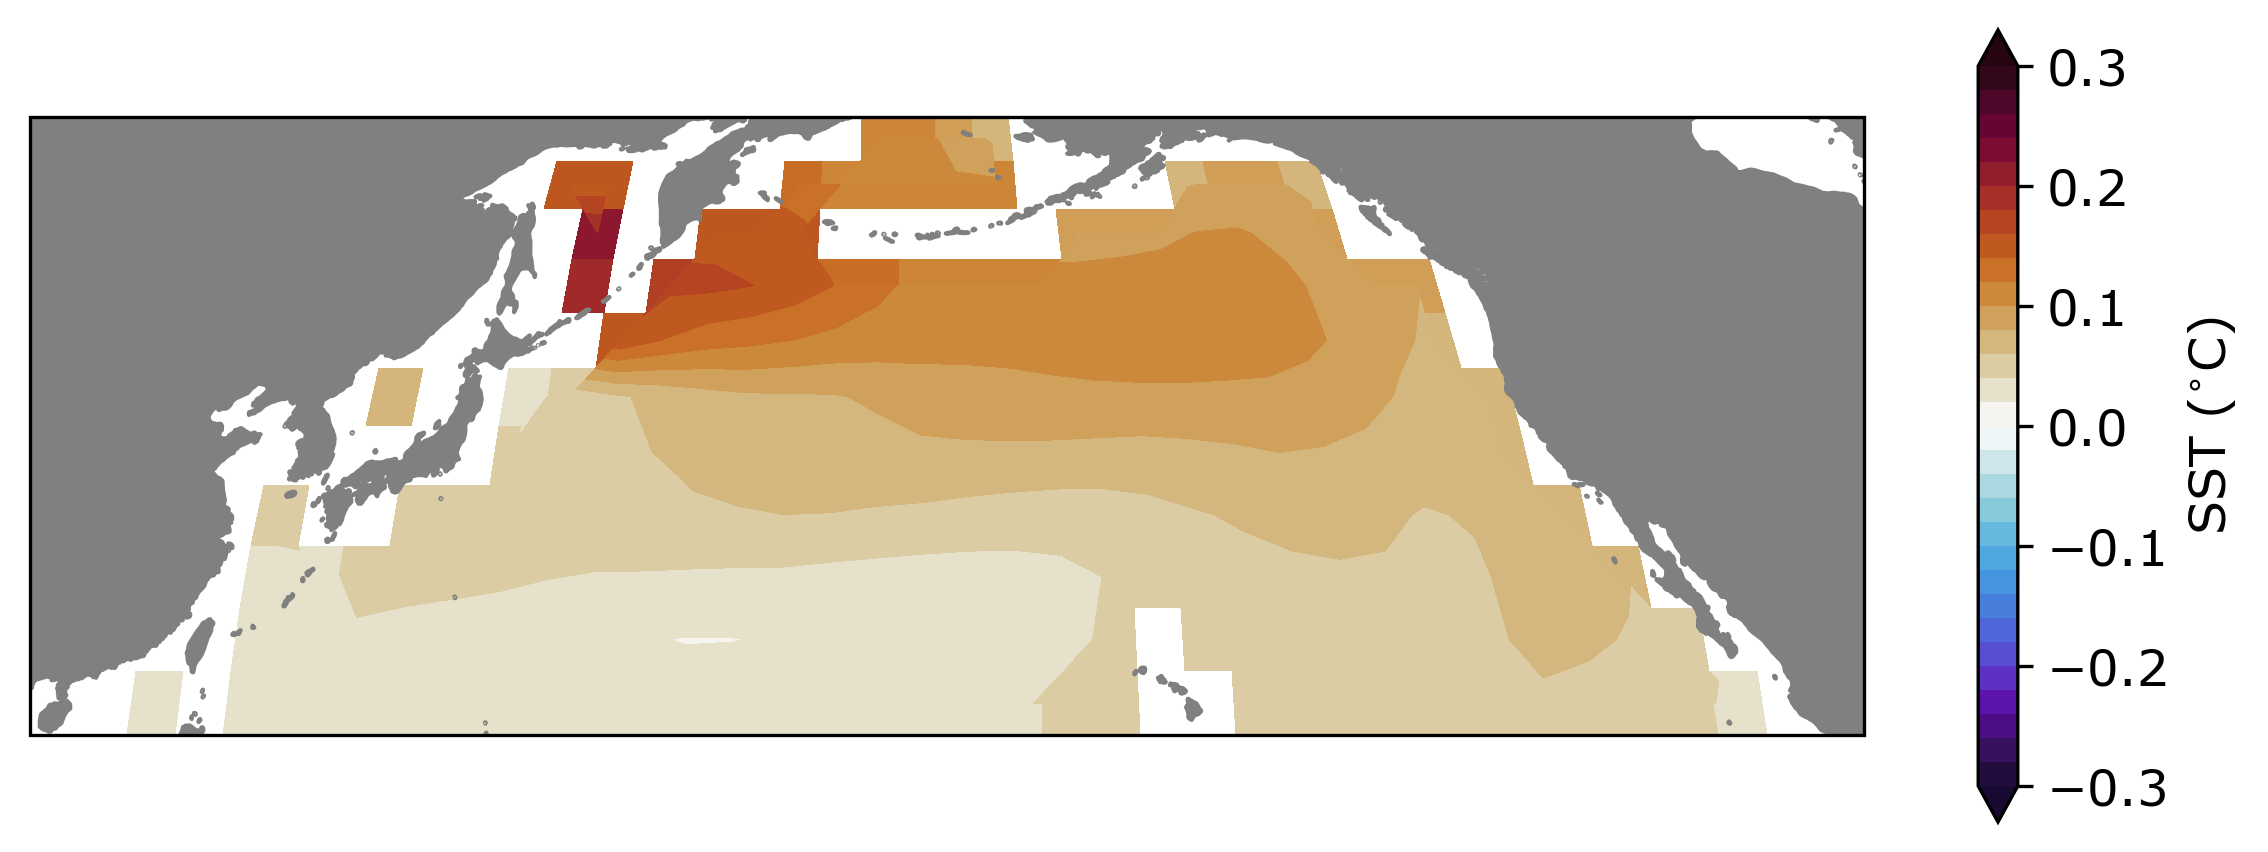

In [9]:
imp.reload(analysisplots)

random_seed = seedlist[bestseed]

fileout = filename + "_seed=" + str(random_seed) +".h5"

tf.random.set_seed(random_seed)
np.random.seed(random_seed) 

full_model = build_model.build_CNN_full(inputdata, outputdata, 
                                                experiment_dict, random_seed)  

full_model.compile(optimizer=tf.keras.optimizers.legacy.SGD(experiment_dict["learning_rate"]),  # optimizer
                    loss=tf.keras.losses.MeanSquaredError(), 
                  )

full_model.load_weights(fileout)

full_model.trainable = False # freeze BN

y_pred_test = full_model.predict(inputtest)
y_pred_val = full_model.predict(inputval) 

bestpattern = allthelinalg.calculate_SC_weighted(y_pred_val,outputval,landmask,latweights)   

patternstr = "figures/CMIP6pattern.png"

analysisplots.plotpattern_SST(bestpattern,lon,lat,outputstd,patternstr)

### Now examine SCA on obs

Take the pattern calculated from the validation data above and project it onto obs, and also the testing members from the GCMs.

5/5 [==============================] - 0s 3ms/step
np conversion done
eof done
np conversion done
eof done


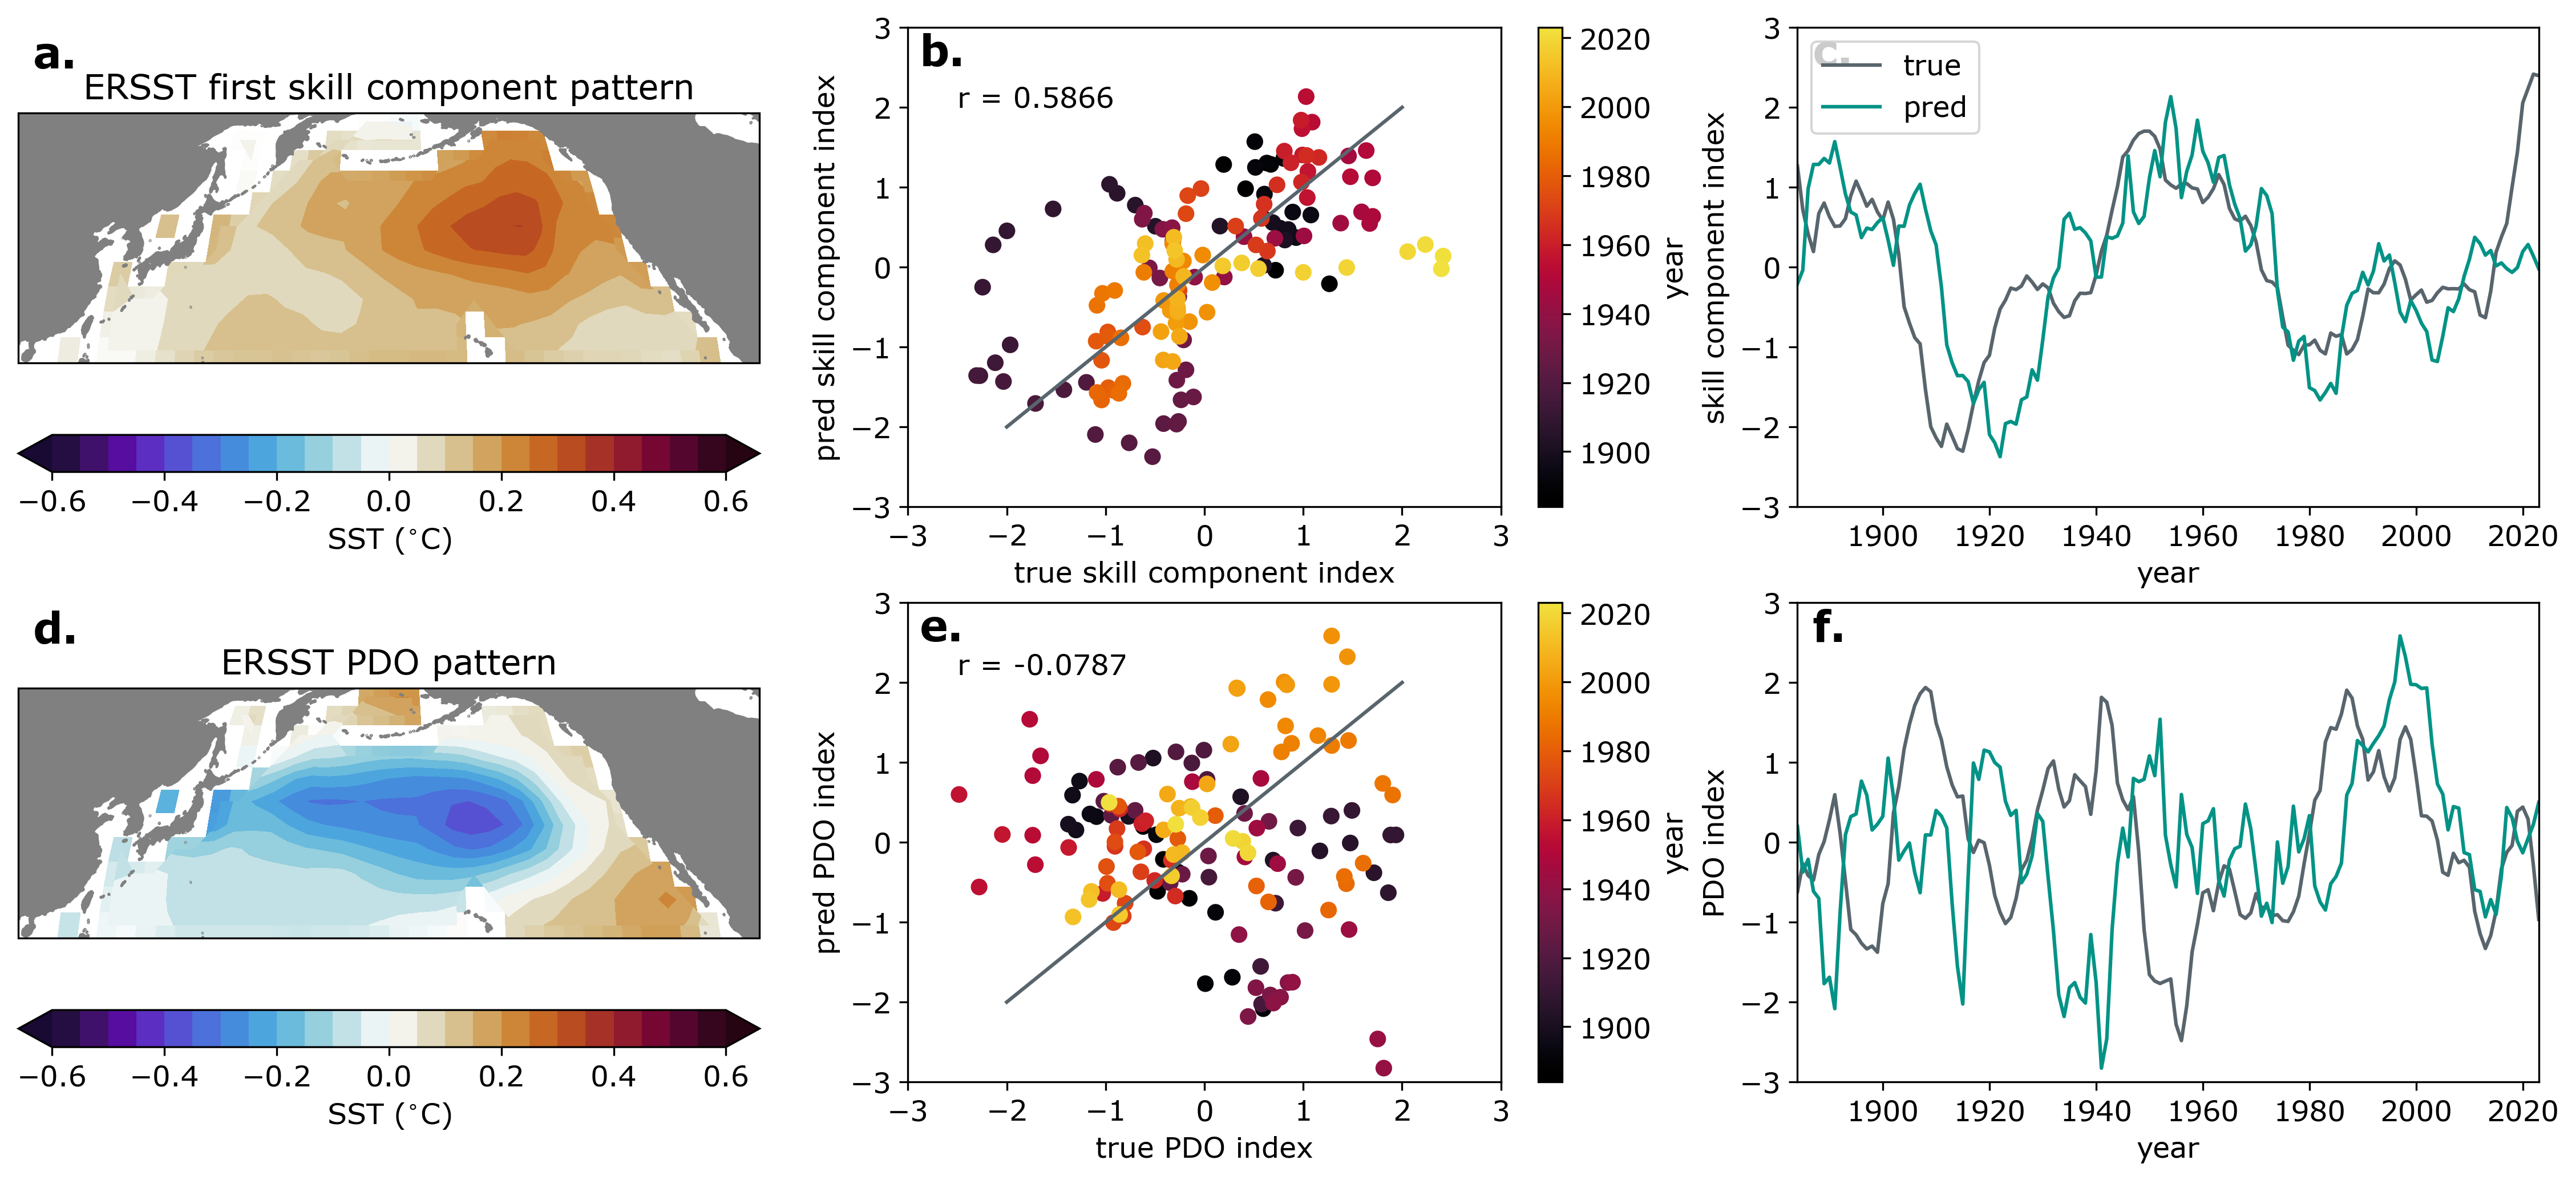

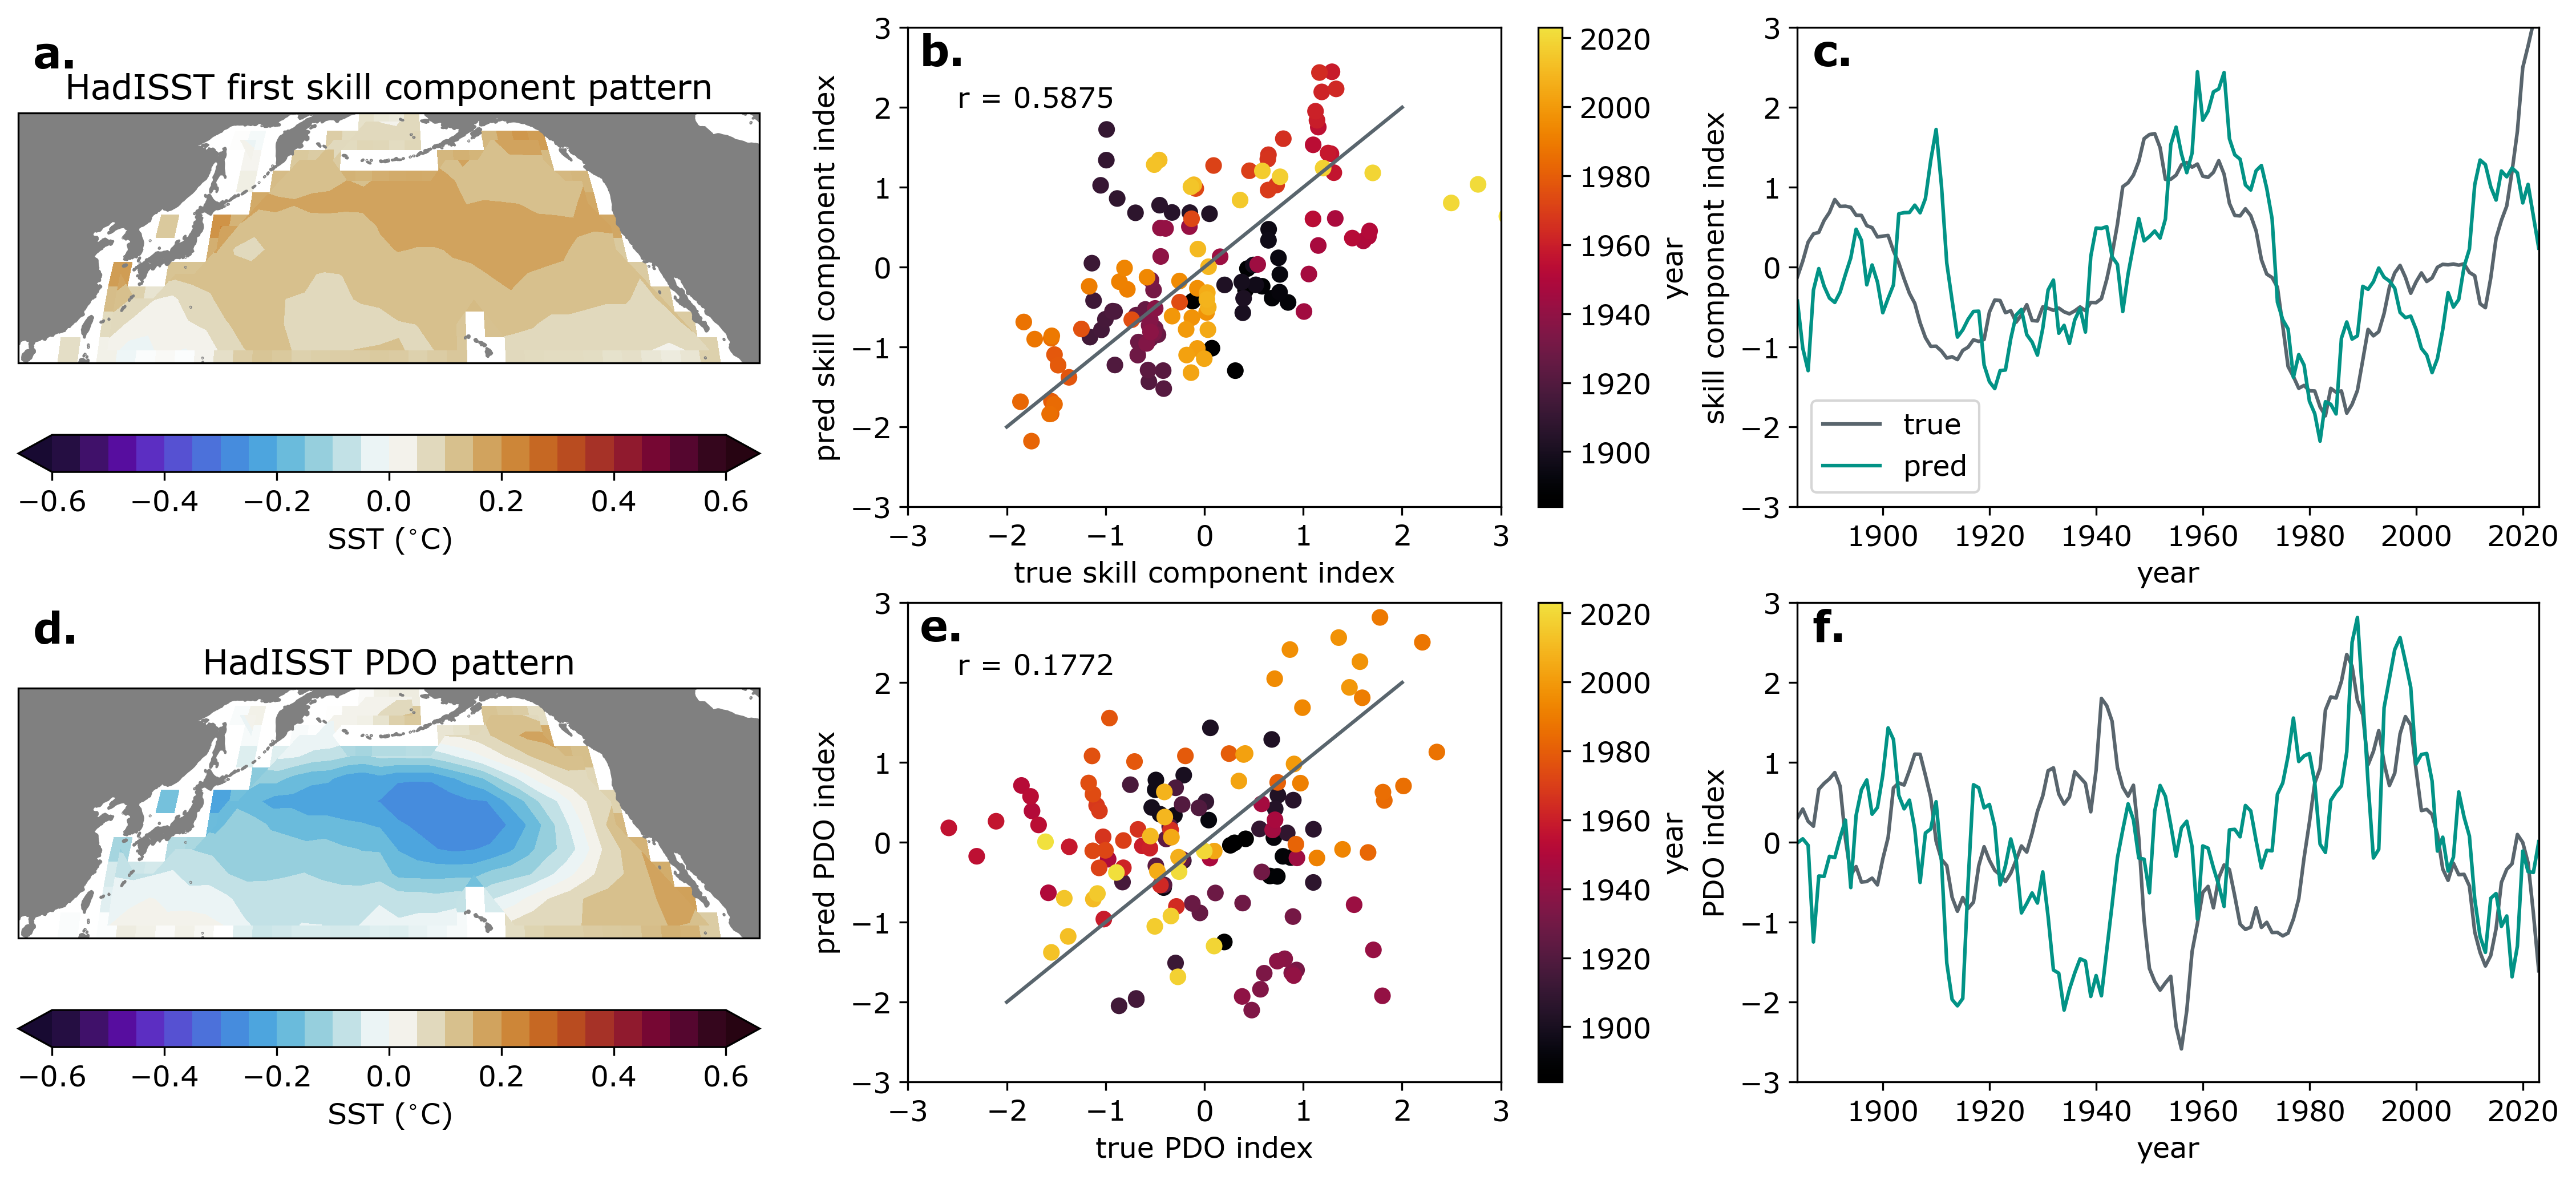

In [10]:
imp.reload(analysisplots)
y_pred_obs_ERSST = full_model.predict(inputobs_ERSST)
y_pred_obs_ERSST[:,np.sum(outputobs_ERSST,axis=0)==0]=0 # zero out land points

y_pred_obs_HadISST = full_model.predict(inputobs_HadISST)
y_pred_obs_HadISST[:,np.sum(outputobs_HadISST,axis=0)==0]=0 # zero out land points

obsPDO_ERSST = preprocessing.PDOobs(experiment_dict,"ERSST")
obsPDO_ERSST = np.asarray(obsPDO_ERSST)

obsPDO_HadISST = preprocessing.PDOobs(experiment_dict,"HadISST")
obsPDO_HadISST = np.asarray(obsPDO_HadISST)

analysisplots.patternplots_SST(bestpattern,obsPDO_ERSST,outputobs_ERSST,y_pred_obs_ERSST,outputval,y_pred_val,
                             landmask,lon,lat,obsyearvec,"ERSST",outputstd)

#analysisplots.bestpatternplot_poster(bestpattern,outputobs_ERSST,y_pred_obs_ERSST,outputval,y_pred_val,
                                     #landmask,lon,lat,obsyearvec,"ERSST",outputstd) # split up subfigures for posters

analysisplots.patternplots_SST(bestpattern,obsPDO_HadISST,outputobs_HadISST,y_pred_obs_HadISST,outputval,y_pred_val,
                             landmask,lon,lat,obsyearvec,"HadISST",outputstd)

for imodel,cmodel in enumerate(modellist):
         
    outputtestloop = reshapengrab(outputtest,imodel,nmodels,nvariant)    
    y_pred_testloop = reshapengrab(y_pred_test,imodel,nmodels,nvariant)    
    
    outputtest_singlemem = outputtestloop[:ntimesteps]
    y_pred_test_singlemem = y_pred_testloop[:ntimesteps]

    #analysisplots.patternplots_SST(bestpattern,PDOpatterns_singlemodel[imodel],outputtest_singlemem,y_pred_test_singlemem,outputval,y_pred_val,
     #                            landmask,lon,lat,modelyearvec,cmodel,outputstd)    

### Hmmmm it appears that we are doing well at predicting obs!

Let's find out just how well. Calculate the correlation coefficent between the SC index in truth and predictions for each individual testing ensemble member for each climate model and then also in the observations.

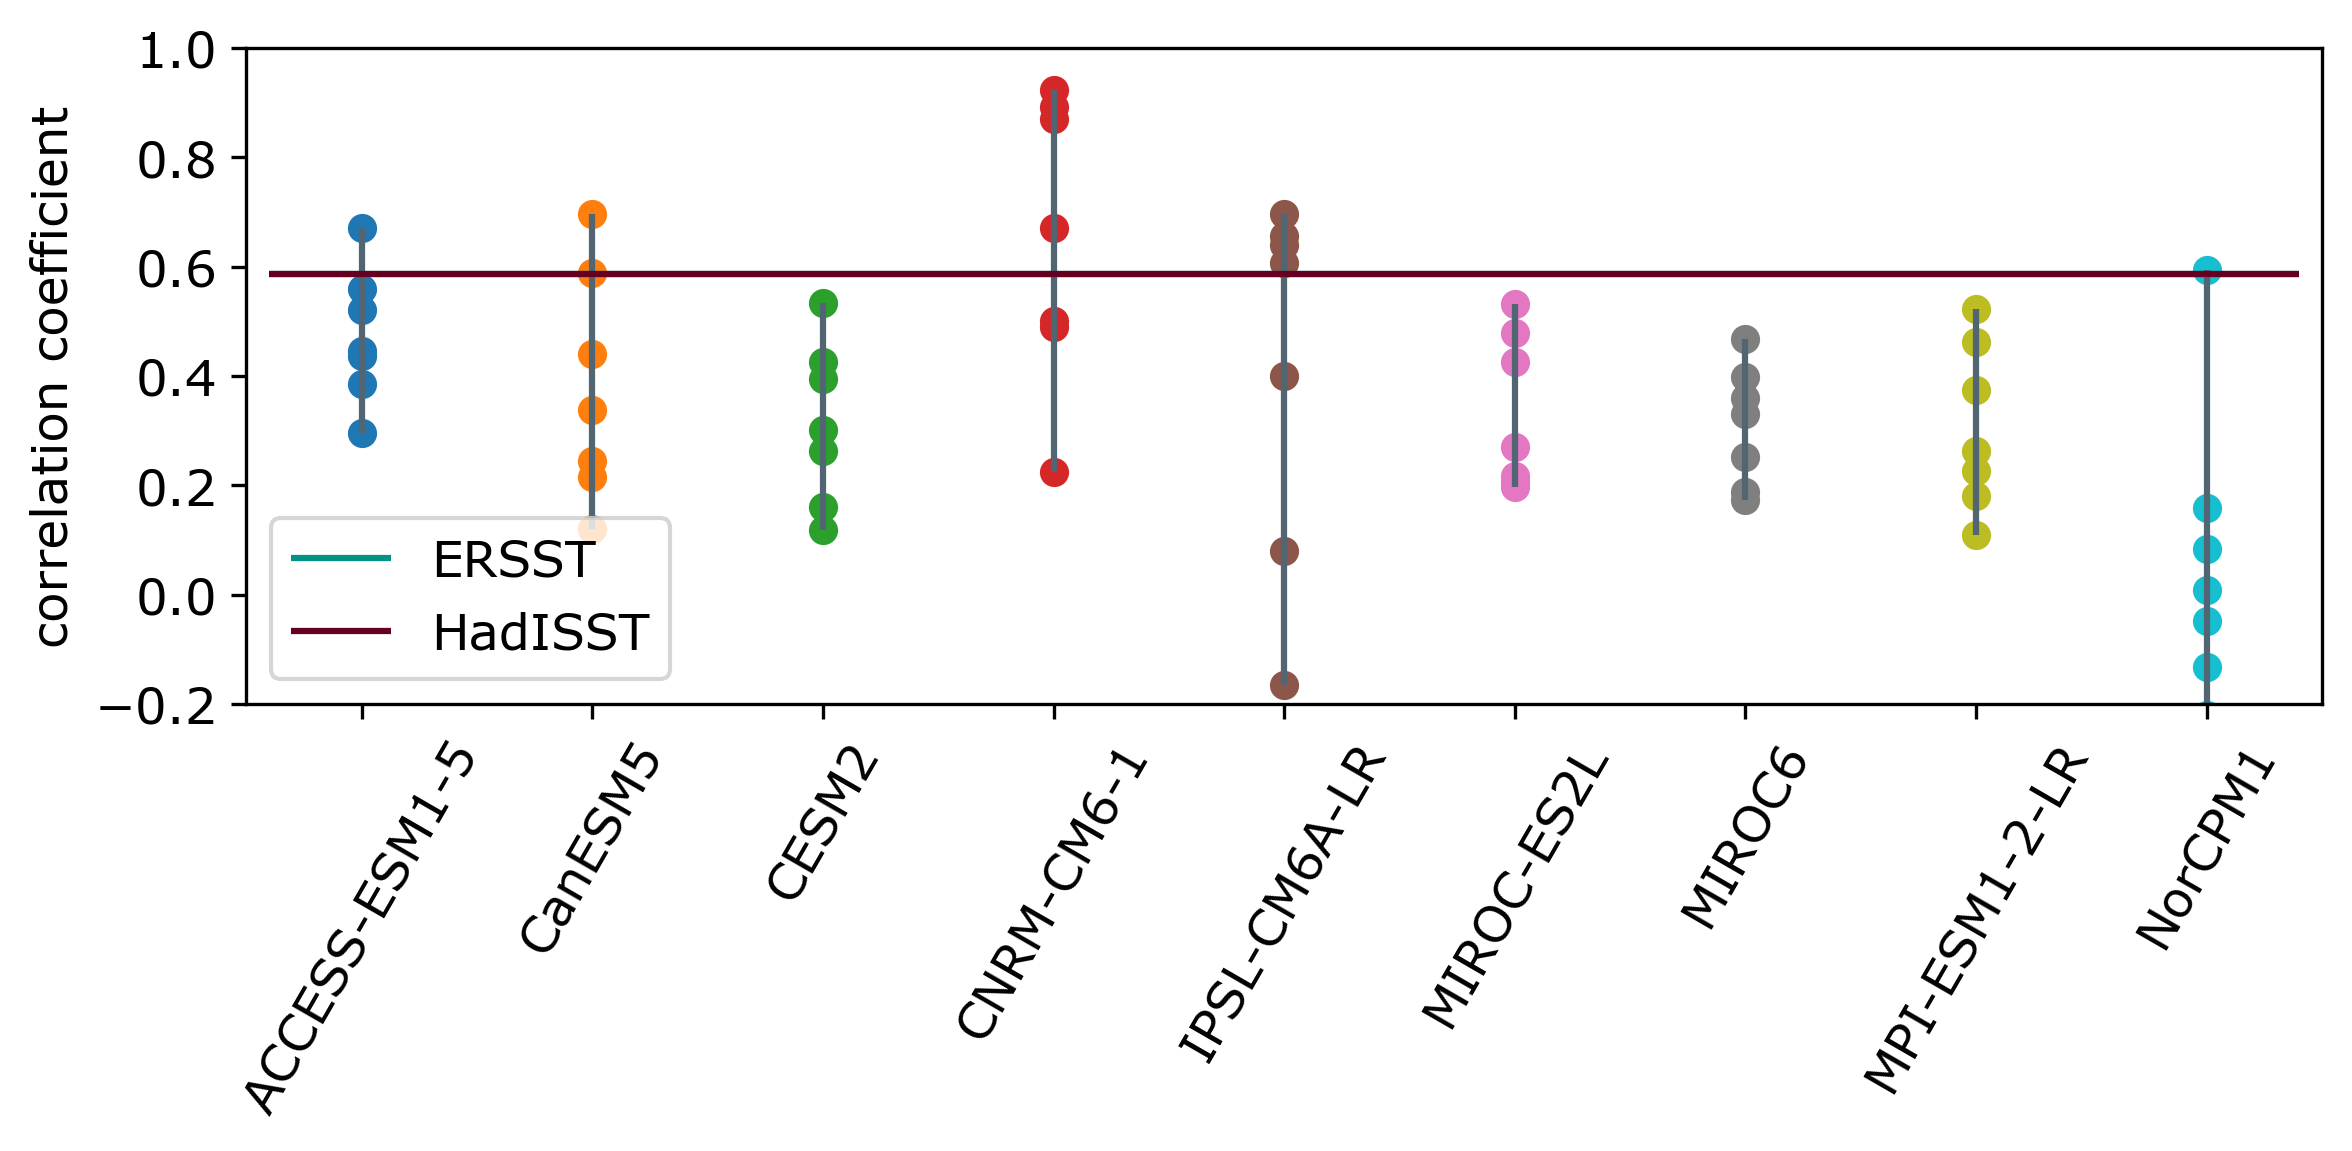

In [11]:
imp.reload(analysisplots)
modelpearsons = model_member_corr(bestpattern,outputtest,y_pred_test,outputval,y_pred_val,nmodels,nvariant,landmask)
obspearson_ERSST,obsps = allthelinalg.corr_indextimeseries(
    bestpattern,outputobs_ERSST,y_pred_obs_ERSST,outputval,y_pred_val,landmask)
obspearson_HadISST,obsps = allthelinalg.corr_indextimeseries(
    bestpattern,outputobs_HadISST,y_pred_obs_HadISST,outputval,y_pred_val,landmask)

obscorrlist = [obspearson_ERSST,
              obspearson_HadISST]

obslabels = ["ERSST","HadISST"]

# savestr = "figures/prettyscatterplot_fullmodel.png"
analysisplots.prettyscatterplot(modelpearsons,obscorrlist,modellist,testvariants,"correlation coefficient",obslabels,None)


### Project the index onto the input data to highlight how the patterns evolve

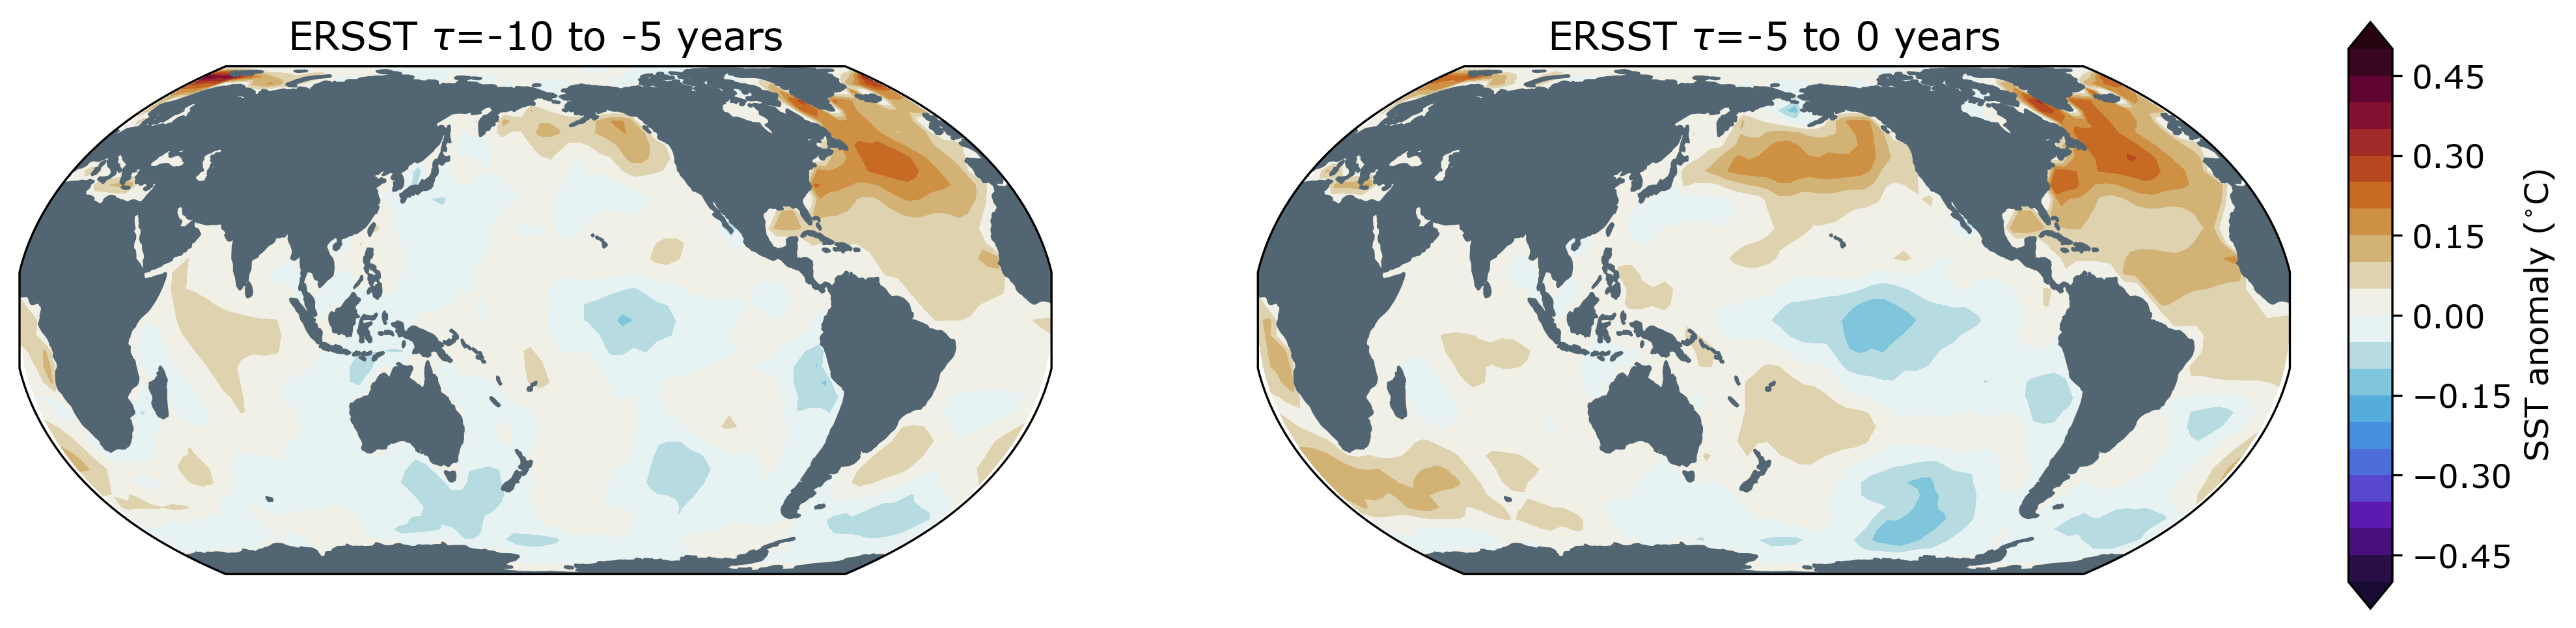

In [12]:
imp.reload(analysisplots)
analysisplots.inputplots(inputobs_ERSST,outputobs_ERSST,bestpattern,landmask,inres,"ERSST")

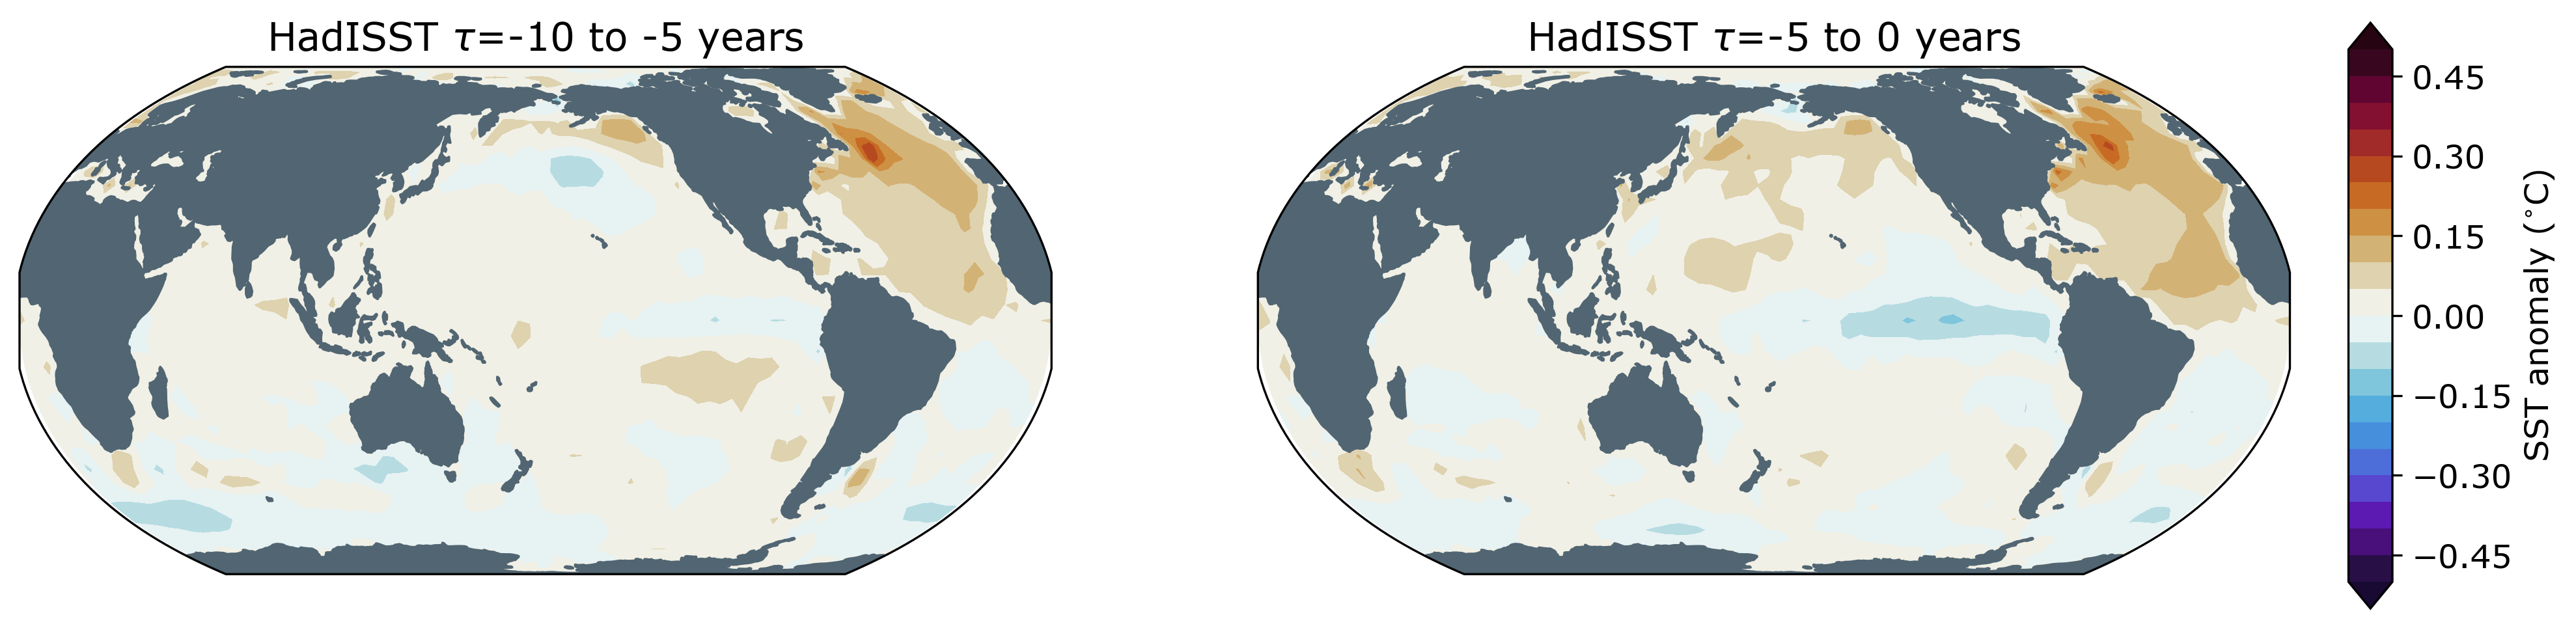

In [13]:
analysisplots.inputplots(inputobs_HadISST,outputobs_HadISST,bestpattern,landmask,inres,"HadISST")

### And each individual model just for fun

In [14]:
# for imodel,cmodel in enumerate(modellist):

#     inputtestloop = reshapengrab(inputtest,imodel,nmodels,nvariant)
#     outputtestloop = reshapengrab(outputtest,imodel,nmodels,nvariant)    
#     y_pred_testloop = reshapengrab(y_pred_test,imodel,nmodels,nvariant)    
    
#     analysisplots.inputplots(inputtestloop,outputtestloop,bestpattern,landmask,inres,cmodel)

### Variance explained by true pattern at each grid point in obs

In [15]:
imp.reload(preprocessing)
obs_ersst = preprocessing.makeoutputonly_obs_flexavg(experiment_dict,"ERSST",[-60,60,0,360],4)
obs_hadisst = preprocessing.makeoutputonly_obs_flexavg(experiment_dict,"HadISST",[-60,60,0,360],4)

biglat = obs_ersst.lat
biglon = obs_ersst.lon

nlatbig = len(biglat)
nlonbig = len(biglon)

obs_ersst = np.asarray(obs_ersst)
obs_hadisst = np.asarray(obs_hadisst)

obs_ersst[np.isnan(obs_ersst)] = 0
obs_hadisst[np.isnan(obs_hadisst)] = 0

In [16]:
SCtimeseries_ERSST = allthelinalg.index_timeseries(outputobs_ERSST,bestpattern,landmask)
SCtimeseries_HadISST = allthelinalg.index_timeseries(outputobs_HadISST,bestpattern,landmask)

R_ERSST = np.empty((nlatbig,nlonbig))
R_HadISST = np.empty((nlatbig,nlonbig))

for ilat in range(nlatbig):
    for ilon in range(nlonbig):
        R_ERSST[ilat,ilon],_ = pearsonr(SCtimeseries_ERSST,obs_ersst[:,ilat,ilon])
        R_HadISST[ilat,ilon],_ = pearsonr(SCtimeseries_HadISST,obs_hadisst[:,ilat,ilon])             


ValueError: x and y must have the same length.

/var/folders/84/qffj5kdx3q15s9xdytp7r01r0000gq/T/ipykernel_80292/4096376389.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


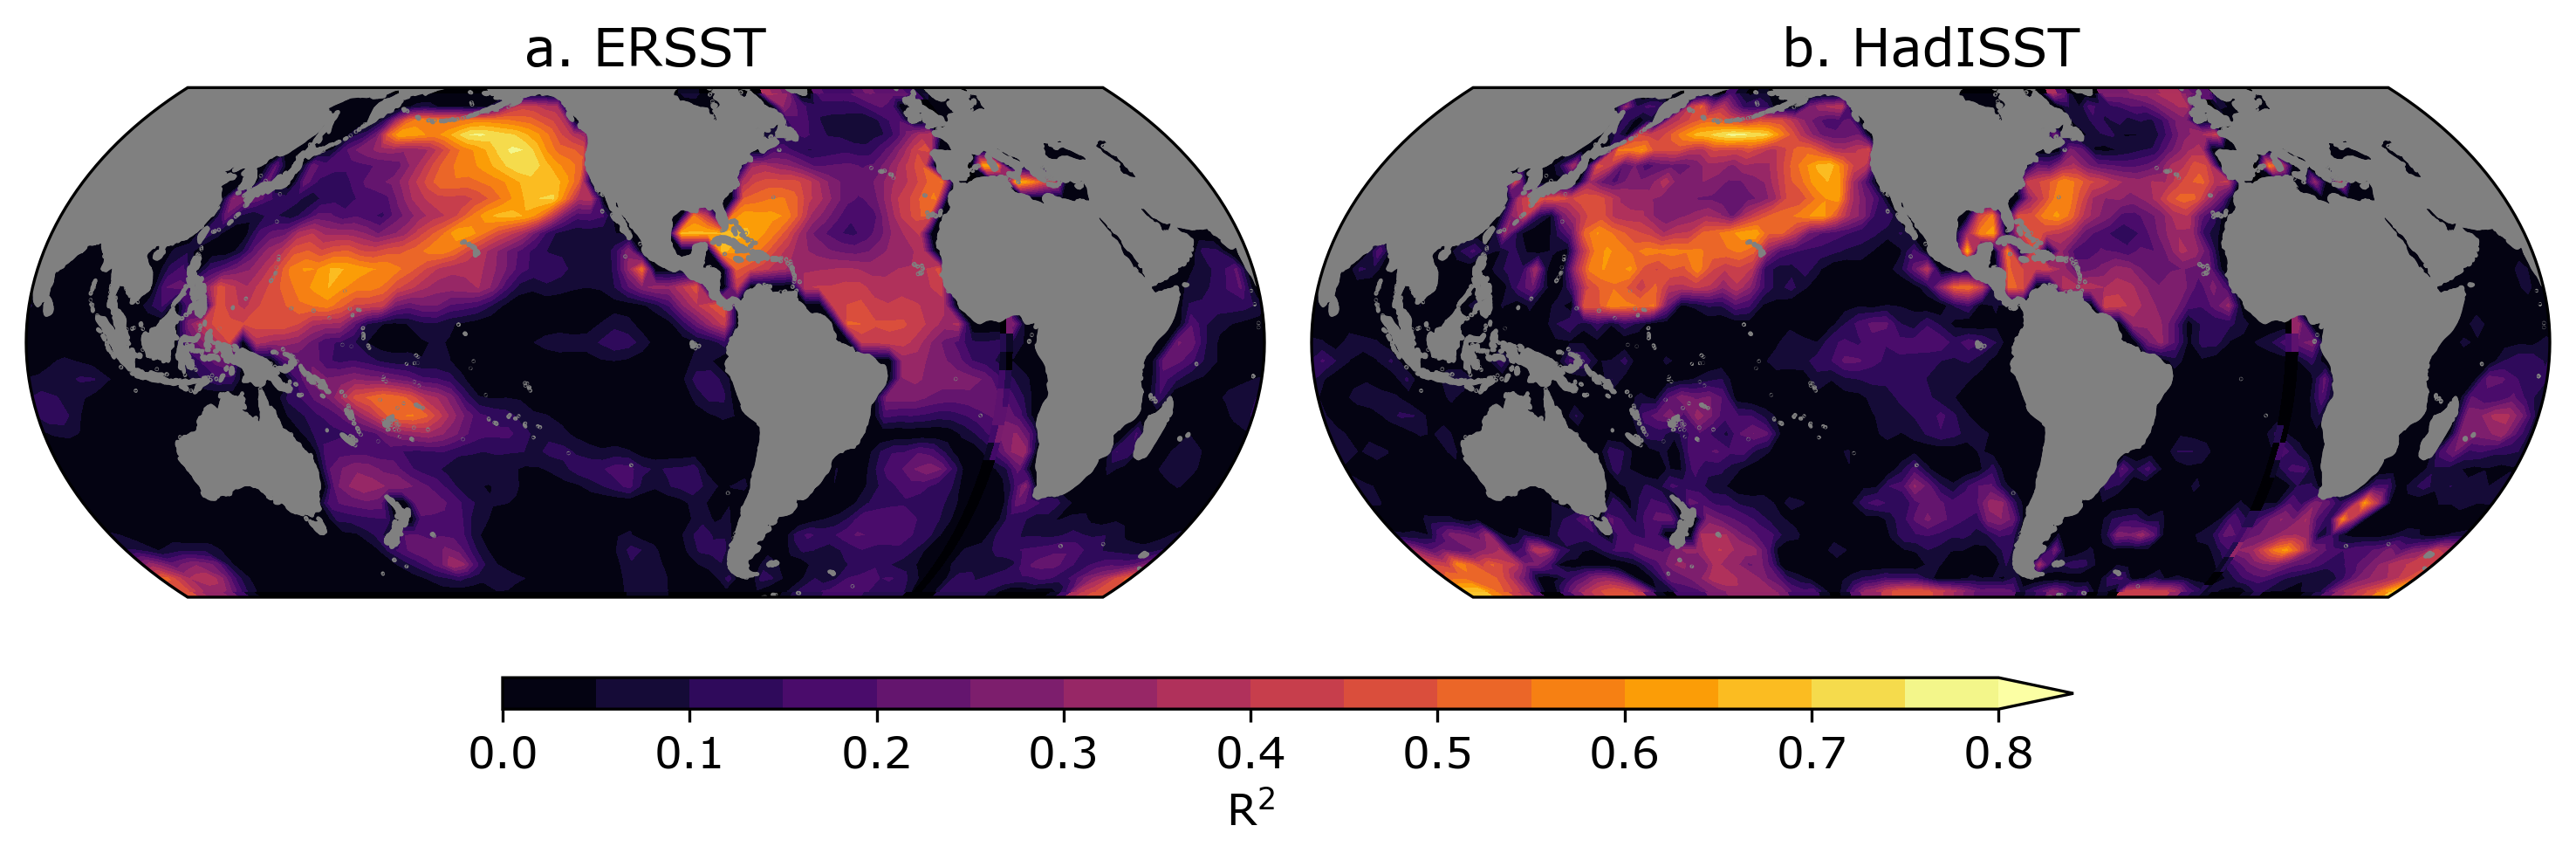

In [ ]:
R_ERSST[np.isnan(R_ERSST)] = 0
R_HadISST[np.isnan(R_HadISST)] = 0

lbound = 0
ubound = 0.8

cmapinc = cmr.ember
bounds = np.arange(lbound,ubound+0.05,0.05)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=cmapinc.N)

plt.figure(figsize=(10,4))

a1=plt.subplot(1,2,1,projection=ccrs.EqualEarth(central_longitude=255))
a1.pcolormesh(biglon,biglat,R_ERSST**2,norm=norm,cmap='inferno',transform=transform)
a1.contourf(biglon,biglat,R_ERSST**2,bounds,cmap='inferno',transform=transform,extend='max')
a1.coastlines(color='gray')
a1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='grey'))
plt.title(r"a. ERSST")

a2=plt.subplot(1,2,2,projection=ccrs.EqualEarth(central_longitude=255))
a2.pcolormesh(biglon,biglat,R_HadISST**2,norm=norm,cmap='inferno',transform=transform)
c=a2.contourf(biglon,biglat,R_HadISST**2,bounds,cmap='inferno',transform=transform,extend='max')
a2.coastlines(color='gray')
a2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='grey'))
plt.title(r"b. HadISST")

cax=plt.axes((0.2,0.15,0.6,0.03))
cbar=plt.colorbar(c,cax=cax,orientation='horizontal')
cbar.ax.set_xlabel(r'R$^2$')
plt.tight_layout()

# plt.savefig("figures/varexplained.png")

plt.show()

##### A simple linear relation for 1-5year SST prediction

(10440, 11, 38)

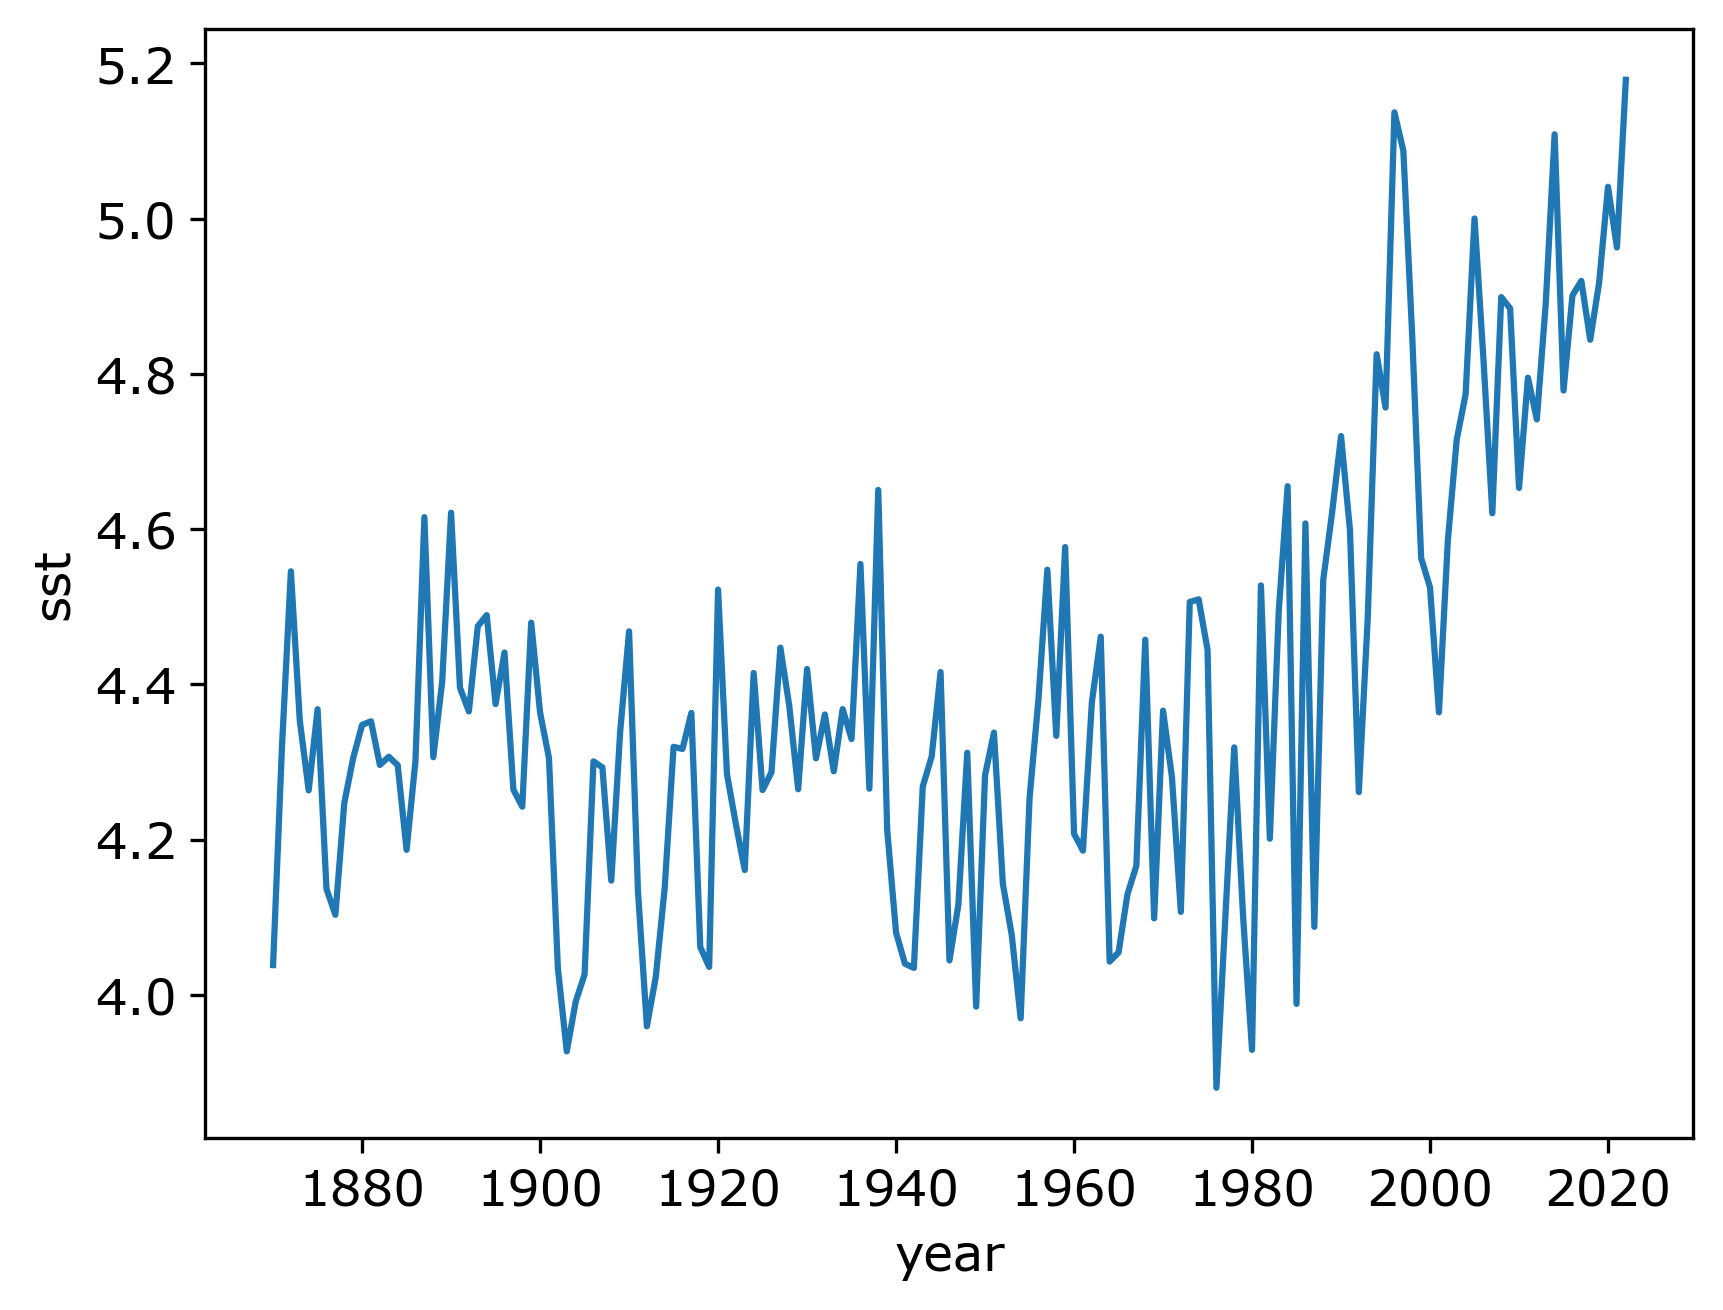

In [50]:
import xarray as xr

dfile = glob.glob("data/HadISST_sst_2x2.nc")[0]
ds = xr.open_dataset(dfile)
da = ds.sst
da = da.where(da>-99)

da = da.groupby("time.year").mean()

da.sel(lat=slice(50,60),lon=slice(140,170),year=slice(1870,2022)).mean(dim=("lat","lon")).plot()

In [42]:
da.time

<xarray.DataArray 'time' (time: 1851)>
array(['1870-01-16T11:59:59.505615234', '1870-02-14T23:59:59.340820312',
       '1870-03-16T11:59:59.340820312', ..., '2024-01-16T12:00:00.000000000',
       '2024-02-15T12:00:00.000000000', '2024-03-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1870-01-16T11:59:59.505615234 ... 2024-03-...
Attributes:
    long_name:      Time
    standard_name:  time